<a href="https://colab.research.google.com/github/MinakoNG63/DSFB/blob/main/20_Supervised_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 20) Supervised Segmentation (Decision Tress and its Visualization on Titanic Dataset)

Term 1 2022 - Instructor: Teerapong Leelanupab

Teaching Assistant:
1. Piyawat Chuangkrud (Sam)
2. Suvapat Manu (Mint)

***

In [ ]:
import pandas as pd
# This is for setting an output to show more row

pd.set_option('display.max_colwidth', None)
# pd.set_option('max_rows', 500)
#pd.set_option('max_colwidth', 400)
# pd.describe_option('max_colwidth')

In [ ]:
#---------------------------------
#download files จาก google drive
#---------------------------------
# Titanic_dataset.zip
#dataurl = 'https://drive.google.com/file/d/1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw/view?usp=sharing'
!gdown --id 1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw

Downloading...
From: https://drive.google.com/uc?id=1t3a4iZr6f4xfPXNl1e3Kw78l3pBiEEVw
To: /content/Titanic_dataset.zip
100% 46.5k/46.5k [00:00<00:00, 35.8MB/s]


In [ ]:
!unzip Titanic_dataset.zip

Archive:  Titanic_dataset.zip
replace titanic.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: titanic.csv             
  inflating: pre_split/test.csv      
  inflating: pre_split/train.csv     
  inflating: description.txt         


## 1. Load data
## 2. Clean data & Split data into features and a target

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def load_data():
  titanic_df = pd.read_csv('titanic.csv')
  return titanic_df

def clean_data(df):
  df['Cabin'] = df['Cabin'].fillna('nocabin')
  df['Age'] = df['Age'].fillna(df['Age'].mean())
  df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])
  return df

def split_data_label(df):
  y = df['Survived']
  X = df.drop('Survived', axis=1)
  return X, y

## 3. Extract Feature

### 3.11 <font color='red'>Feature Extraction **function**</font>

***
We can re-start to run from here

In [ ]:
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.preprocessing import normalize
import re

# create a special function to extract the initial
def getinitialfeature(df):
  initial = []
  for i in range(len(df)):
    fn = df['Name'][i]
    initial.append(fn.split(',')[1].split('.')[0].strip())
  return initial

# create a special function to extract the ticket flag (Contain only number or not)
def getnumticket(ticketList):
  numticket = []
  for i in range(len(ticketList)):
    try:
      int(ticketList[i])
      numticket.append(1)
    except:
      numticket.append(0)
  return numticket

# create a special function to extract the Alphabet Prefix of Ticket
def getAlphabetPrefixTicket(df):
    #alphaPrefixDict = []
    alphaPrefixTicket = []
    for i in range(len(df)):
        ticket = df['Ticket'].values[i]
        res = re.findall('^[\w/.]+\s|$', ticket)[0]
        #res = re.findall('^[\w?.!/;:]+\s|$', ticket)[0]

        # res = re.search('^[\w/.]+\s|$', ticket).group()
        # alphaPrefixDict.append((ticket, res.strip()))

        ticketCode =  'Ticket-' + res.strip().translate({ord(i):None for i in '/.'})
        alphaPrefixTicket.append(ticketCode)
#     x = np.array(alphaPrefixTicket)
#     print(np.unique(x))
    df['alphaPrefixTicket'] = alphaPrefixTicket
    alphaPrefix_cats  = [['Ticket-', 'Ticket-A4', 'Ticket-A5', 'Ticket-AS', 'Ticket-C', 'Ticket-CA',
         'Ticket-CASOTON', 'Ticket-FC', 'Ticket-FCC', 'Ticket-Fa', 'Ticket-PC',
         'Ticket-PP', 'Ticket-PPP', 'Ticket-SC', 'Ticket-SCA4', 'Ticket-SCAH',
         'Ticket-SCOW', 'Ticket-SCPARIS', 'Ticket-SCParis', 'Ticket-SOC', 'Ticket-SOP',
         'Ticket-SOPP', 'Ticket-SOTONO2', 'Ticket-SOTONOQ', 'Ticket-SP',
         'Ticket-STONO', 'Ticket-STONO2', 'Ticket-SWPP', 'Ticket-WC', 'Ticket-WEP']]
#     alphaPrefixDummy = pd.get_dummies(df['alphaPrefixTicket'], columns = alphaPrefix_cats, drop_first=True)

    alphaPrefix_ohe = OneHotEncoder(categories = alphaPrefix_cats, drop = 'first')
    alphaPrefix_feature_arr = alphaPrefix_ohe.fit_transform(df[['alphaPrefixTicket']]).toarray()
    #confirm that categories are sorted in the same as pre-defined list
    #print(alphaPrefix_ohe.categories_)
    alphaPrefix_cats[0].remove('Ticket-')
    alphaPrefix_feature_labels = alphaPrefix_cats[0]
    alphaPrefixDummy = pd.DataFrame(alphaPrefix_feature_arr, columns=alphaPrefix_feature_labels)
    return alphaPrefixDummy

# -------------------------------------------------------------------------------------
# create a very special function to put what we do all together
# -------------------------------------------------------------------------------------
def extract_feat(df):
  X = df.copy()
  X = X.drop('PassengerId', axis=1)

  # 3.1 Cabin Zone
  X['CabinZone'] = X['Cabin'].str[0]

  # 3.2 Initial of passenger
  X['Initial'] = getinitialfeature(X)

  # 3.3 ticket flag
  ticketList = X['Ticket'].values
  X['Only_Num_in_Ticket'] = getnumticket(ticketList)

  # ******************************** Additional Block 1: Extract More Features ******************************
  # 3.x ticket prefix
  alphaPrefix=getAlphabetPrefixTicket(X)
  X = X.drop('alphaPrefixTicket', axis=1)
  # *********************************************************************************************************

  # 3.4 Quantize Fare
  quantile_list = [0, .25, .5, .75, 1.]
  quantile_labels = ['0-25Q', '25-50Q', '50-75Q', '75-100Q']
  X['Fare_Adaptive_Bin'] = pd.qcut(X['Fare'], q=quantile_list, labels=quantile_labels)

  # 3.7 Drop unwanted features
  # from 3.1 Cabin
  X.drop('Cabin', axis=1, inplace=True)
  # from 3.2 Name
  X.drop('Name', axis=1, inplace=True)
  # from 3.3 Ticket
  X.drop('Ticket', axis=1, inplace=True)

  # 3.8 Encode all categorical features

  # ******************************** Additional Block 2: Encode Pclass **************************************
  # 3.8.x Apply OneHotEncoding to PClass
  pclass_features = pd.get_dummies(X['Pclass'])
  feature_labels = ['Pclass_' + str(cls_label) for cls_label in pclass_features.columns]
  pclass_features.columns = feature_labels
  X = X.drop(columns='Pclass', axis=1)
  # *********************************************************************************************************

  # 3.8.1 Apply OneHotEncoding to CabinZone
  cabin_zone_features = pd.get_dummies(X['CabinZone'])
  feature_labels = ['CabinZone_' + str(cls_label) for cls_label in cabin_zone_features.columns]
  cabin_zone_features.columns = feature_labels

  # 3.8.2 Apply OneHotEncoding to Embarked
  embarked_features = pd.get_dummies(X['Embarked'])
  feature_labels = ['Embarked_' + str(cls_label) for cls_label in embarked_features.columns]
  embarked_features.columns = feature_labels

  # 3.8.3 Apply OneHotEncoding to Fare_Adaptive_Bin
  fare_adap_bin_features = pd.get_dummies(X['Fare_Adaptive_Bin'])
  feature_labels = ['FareAdapBin_' + str(cls_label) for cls_label in fare_adap_bin_features.columns]
  fare_adap_bin_features.columns = feature_labels

  # 3.8.4 Apply Dummy Coding Scheme to Sex (Male flag)
  male_features = pd.get_dummies(X['Sex'], drop_first=True)


  # ******************************** Additional Block 3: Encode Initial *************************************
  # 3.8.5.1 Apply LabelEncoding to Initial
  # enc = LabelEncoder()
  # initial_arr = enc.fit_transform(X['Initial'])
  # initial_features = pd.DataFrame({'Initial_Feature': initial_arr})

  # 3.8.5.2 Apply OneHotEncoding to Initial
  initial_features = pd.get_dummies(X['Initial'])
  feature_labels = ['Initial_' + str(cls_label) for cls_label in initial_features.columns]
  initial_features.columns = feature_labels
  # *********************************************************************************************************


  # *********************************** Additional Block 4: Concatenate Features ****************************
  # 3.9 Cancatenate all features to the original dataframe
  # X = pd.concat([X,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features],axis=1)

  # ****************Add two more features*******************
  #--------Option 1: add AlphaPrefix-------
  # X = pd.concat([X,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features,alphaPrefix],axis=1)
  #--------Option 2: add Pclass and AlphaPrefix-------
  X = pd.concat([X,pclass_features,cabin_zone_features,embarked_features,fare_adap_bin_features, male_features,initial_features,alphaPrefix],axis=1)
  # *********************************************************************************************************


  # 3.10 Filter in only numeric features to train a model
  X = X._get_numeric_data()
  #display(X)
  #print(X.shape)

  # 3.11 Apply feature normalization
  # X.loc[:, X.columns] = normalize(X, norm='max')
  # display(X)
  return X

# 4. Create Predictive Model

## 4.1 Simple hold-out spliting

In [ ]:
from sklearn.model_selection import train_test_split

def simple_hold_out_spliting(X, y, test_size):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = 1)
  return X_train, X_test, y_train, y_test

----- Histogram of 'Survived' -----


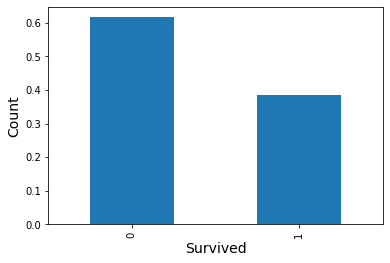

Traning set - negative class ratio: 0.62


In [ ]:
  # 1. Get data
  titanic_df = load_data()

  # 2.1 Clean data
  clean_titanic_df = clean_data(titanic_df.copy())

  print("----- Histogram of 'Survived' -----")
  plt.figure()
  p = clean_titanic_df.Survived.value_counts(normalize=True).plot(kind='bar')
  p.set_xlabel("Survived",fontsize=14)
  p.set_ylabel("Count",fontsize=14)
  plt.show()
  print("Traning set - negative class ratio: " + str(round(len(clean_titanic_df[clean_titanic_df['Survived']==0])/len(clean_titanic_df),2)))

  # 2.2 Split data into X (Features) and y (Target)
  X, y = split_data_label(clean_titanic_df)

  # 3. Extract feature
  X = extract_feat(X)

  extracted_clean_titanic_df = pd.concat([X,y],axis=1)

## 4.2 Train/fit model on Decision Tree

***


**Entropy** ($H$) and **information gain** ($IG$) are useful tools for measuring the effectiveness of a split on the data. Entropy measures how random data is, information gain is a measure of the reduction in randomness after performing a split.


<figure>
<center>
<img src='https://www.it.kmitl.ac.th/~teerapong/Exxon/Week2/images/dsfb_0304.png' alt='Splitting the "write-off" sample' height=50% width=50%/>
<figcaption><em>Figure 1. Splitting the "write-off" sample into two segments, based on splitting the Balance attribute (account balance) at 50K.</em></figcaption></center>
</figure>

<figure>
<center>
<img src='https://www.it.kmitl.ac.th/~teerapong/Exxon/Week2/images/dsfb_0305.png' alt='classification tree split' height=50% width=50%/>
<figcaption><em>Figure 2. A classification tree split on the three-values Residence attribute.
</em></figcaption></center>
</figure>

Given the data, it is fairly straight forward to calculate both of these quantities.

### 4.2.1 Functions to get the entropy and IG

In [ ]:
def entropy(target_column):
    """
        computes -sum_i p_i * log_2 (p_i) for each i
    """
    # get the counts of each target value
    target_counts = target_column.value_counts().astype(float).values
    total = target_column.count()
    # compute probas
    probas = target_counts/total
    # p_i * log_2 (p_i)
    entropy_components = probas * np.log2(probas)
    # return negative sum
    return - entropy_components.sum()

def information_gain(df, info_column, target_column, threshold):
    """
        computes H(target) - H(target | info > thresh) - H(target | info <= thresh)
    """
    # split data
    data_above_thresh = df[df[info_column] > threshold]
    data_below_thresh = df[df[info_column] <= threshold]
    # get entropy
    H = entropy(df[target_column])
    entropy_above = entropy(data_above_thresh[target_column])
    entropy_below = entropy(data_below_thresh[target_column])
    # compute weighted average
    ct_above = data_above_thresh.shape[0]
    ct_below = data_below_thresh.shape[0]
    tot = float(df.shape[0])
    return H - entropy_above*ct_above/tot - entropy_below*ct_below/tot

Now that we have a way of calculating $H$ and $IG$, let's test our prior hunch, that using 50 as a split on fare allows us to determine if someone will survive.

In [ ]:
threshold = 50
prior_entropy = entropy(extracted_clean_titanic_df["Survived"])
IG = information_gain(extracted_clean_titanic_df, "Fare", "Survived", threshold)
print ("IG of %.4f using a threshold of %.2f given a prior entropy of %.4f" % (IG, threshold, prior_entropy))

IG of 0.0000 using a threshold of 50.00 given a prior entropy of 0.9607


How good was our guess of 50? Let's loop through all possible splits on fare and see what is the best!



In [ ]:
def best_threshold(df, info_column, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0

    for thresh in df[info_column]:
        IG = criteria(df, info_column, target_column, thresh)
        if IG > maximum_ig:
            maximum_ig = IG
            maximum_threshold = thresh

    return (maximum_threshold, maximum_ig)

maximum_threshold, maximum_ig = best_threshold(extracted_clean_titanic_df, "Fare", "Survived")

print ("the maximum IG we can achieve splitting on weight is %.4f using a thresh of %.2f" % (maximum_ig, maximum_threshold))

the maximum IG we can achieve splitting on weight is 0.0756 using a thresh of 0.73



### 4.2.2 This now begs the question: what feature gives the most effective split?

In [ ]:
def best_split(df, info_columns, target_column, criteria=information_gain):
    maximum_ig = 0
    maximum_threshold = 0
    maximum_column = ""

    for info_column in info_columns:
        thresh, ig = best_threshold(df, info_column, target_column, criteria)

        if ig > maximum_ig:
            maximum_ig = ig
            maximum_threshold = thresh
            maximum_column = info_column

    return maximum_column, maximum_threshold, maximum_ig

max_col, max_threshold, max_ig = best_split(extracted_clean_titanic_df, X.columns, "Survived")

print ("The best column to split on is %s giving us a IG of %.4f using a thresh of %.2f" % (max_col, max_ig, max_threshold))

The best column to split on is Initial_Mr giving us a IG of 0.2312 using a thresh of 0.00


### 4.2.3 The Classifier Tree: Recursive Splitting
Of course, splitting the data one time sometimes isn't enough to make accurate categorical predictions. However, we can continue to split the data recursively, building a tree-structured model that may give better results. This recursive splitting is the basis for a "decision tree classifier" or "classifier tree", a popular and powerful class of machine learning algorithm. In particular, this specific algorithm is known as ID3 for Iterative Dichotomizer.

What are some other ways you might consider splitting the data?

In [ ]:
X

,Age,SibSp,Parch,Fare,Only_Num_in_Ticket,Pclass_1,Pclass_2,Pclass_3,CabinZone_A,CabinZone_B,CabinZone_C,CabinZone_D,CabinZone_E,CabinZone_F,CabinZone_G,CabinZone_T,CabinZone_n,Embarked_C,Embarked_Q,Embarked_S,FareAdapBin_0-25Q,FareAdapBin_25-50Q,FareAdapBin_50-75Q,FareAdapBin_75-100Q,male,Initial_Capt,Initial_Col,Initial_Don,Initial_Dr,Initial_Jonkheer,Initial_Lady,Initial_Major,Initial_Master,Initial_Miss,Initial_Mlle,Initial_Mme,Initial_Mr,Initial_Mrs,Initial_Ms,Initial_Rev,Initial_Sir,Initial_the Countess,Ticket-A4,Ticket-A5,Ticket-AS,Ticket-C,Ticket-CA,Ticket-CASOTON,Ticket-FC,Ticket-FCC,Ticket-Fa,Ticket-PC,Ticket-PP,Ticket-PPP,Ticket-SC,Ticket-SCA4,Ticket-SCAH,Ticket-SCOW,Ticket-SCPARIS,Ticket-SCParis,Ticket-SOC,Ticket-SOP,Ticket-SOPP,Ticket-SOTONO2,Ticket-SOTONOQ,Ticket-SP,Ticket-STONO,Ticket-STONO2,Ticket-SWPP,Ticket-WC,Ticket-WEP
0,1.000000,0.045455,0.000000,0.329545,0.000000,0.000000,0.000000,0.045455,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.045455,0.000000,0.00000,0.045455,0.045455,0.000000,0.000000,0.000000,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.045455,0.000000,0.0,0.000000,0.0,0.0,0.0,0.045455,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
1,0.533084,0.014029,0.000000,1.000000,0.000000,0.014029,0.000000,0.000000,0.0,0.000000,0.014029,0.0,0.0,0.0,0.0,0.0,0.000000,0.014029,0.00000,0.000000,0.000000,0.000000,0.000000,0.014029,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.014029,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.014029,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
2,1.000000,0.000000,0.000000,0.304808,0.000000,0.000000,0.000000,0.038462,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.038462,0.000000,0.00000,0.038462,0.000000,0.038462,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.038462,0.0,0.000000,0.0
3,0.659134,0.018832,0.000000,1.000000,0.018832,0.018832,0.000000,0.000000,0.0,0.000000,0.018832,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.018832,0.000000,0.000000,0.000000,0.018832,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.018832,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
4,1.000000,0.000000,0.000000,0.230000,0.028571,0.000000,0.000000,0.028571,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.028571,0.000000,0.00000,0.028571,0.000000,0.028571,0.000000,0.000000,0.028571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.028571,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,1.000000,0.000000,0.000000,0.481481,0.037037,0.000000,0.037037,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.037037,0.000000,0.00000,0.037037,0.000000,0.037037,0.000000,0.000000,0.037037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.037037,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0
887,0.633333,0.000000,0.000000,1.000000,0.033333,0.033333,0.000000,0.000000,0.0,0.033333,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.033333,0.000000,0.000000,0.033333,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,

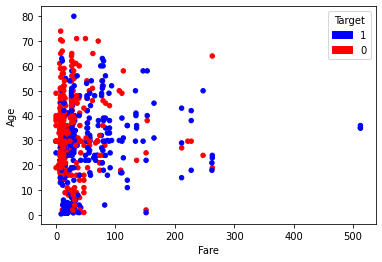

In [ ]:
import matplotlib.patches as mpatches

cmap = {1: 'blue', 0: 'red'}
X.plot(kind="scatter", x="Fare", y="Age", c=[cmap[c] for c in y])
plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc=1, title="Target", frameon=True)
plt.show()

Rather than build a classifier tree from scratch (think if you could now do this!) let's use sklearn's implementation which includes some additional functionality.

# 5. Decision Tree in Sklearn. <font color='red'> Below is what we commonly use </font>

In [ ]:
# 4. Train model
X_train, X_test, y_train, y_test = simple_hold_out_spliting(X, y, 0.2)

In [ ]:
#---------------------------------
#download files จาก google drive
#---------------------------------
# DecisionTree_Images.zip
#dataurl = 'https://drive.google.com/file/d/1S2xBCzTLDDG-bVcmh4LwkgzIMDcmyBPh/view?usp=sharing'
!gdown --id 1S2xBCzTLDDG-bVcmh4LwkgzIMDcmyBPh

Downloading...
From: https://drive.google.com/uc?id=1S2xBCzTLDDG-bVcmh4LwkgzIMDcmyBPh
To: /content/DecisionTree_Images.zip
100% 112k/112k [00:00<00:00, 32.6MB/s]


In [ ]:
!unzip DecisionTree_Images

Archive:  DecisionTree_Images.zip
   creating: DecisionTree_Images/
  inflating: DecisionTree_Images/.DS_Store  
  inflating: DecisionTree_Images/tree.png  
  inflating: DecisionTree_Images/tree.dot  


In [ ]:
from sklearn.tree import DecisionTreeClassifier
# Let's define the model (tree)
decision_tree = DecisionTreeClassifier(max_depth=3, criterion="entropy")   # Look at those 2 arguments !!!
# Let's tell the model what is the data
decision_tree.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

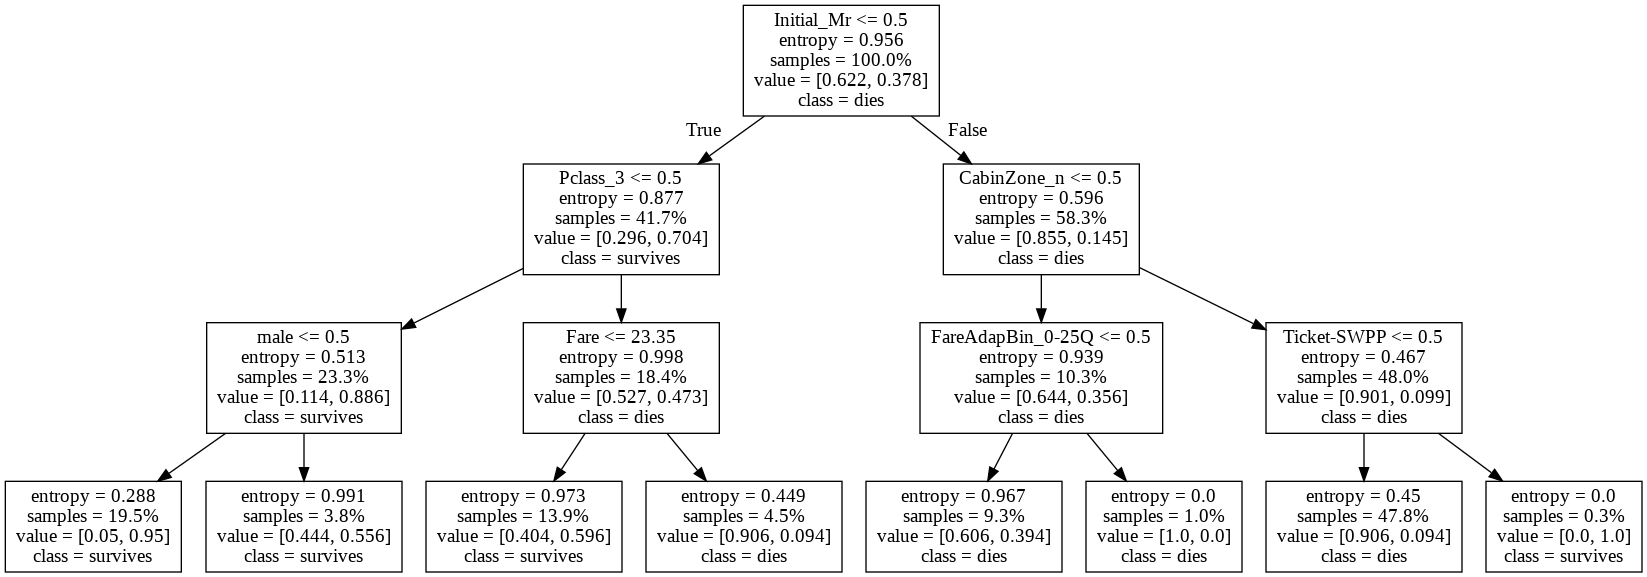

In [ ]:
import os
from IPython.display import Image
from sklearn.tree import export_graphviz

def visualize_tree(decision_tree, feature_names, class_names, directory="./DecisionTree_Images", name="tree",proportion=True):
    # Export our decision tree to graphviz format
    dot_name = "%s/%s.dot" % (directory, name)
    dot_file = export_graphviz(decision_tree, out_file=dot_name,
                               feature_names=feature_names, class_names=class_names,proportion=proportion)
    # Call graphviz to make an image file from our decision tree
    image_name = "%s/%s.png" % (directory, name)
    os.system("dot -T png %s -o %s" % (dot_name, image_name))
    # Return the .png image so we can see it
    return Image(filename=image_name)

visualize_tree(decision_tree, X_train.columns, ["dies", "survives"])

Let's look at `"age"` and `"fare"`, including the **DECISION SURFACE!!**

More details for this graph: [sklearn decision surface](https://scikit-learn.org/0.18/auto_examples/tree/plot_iris.html)

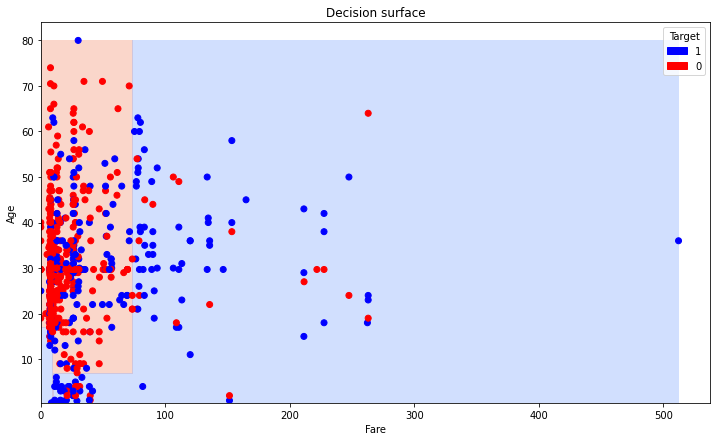

In [ ]:
def Decision_Surface(data, col1, col2, target, model, probabilities=False):
    # Get bounds
    x_min, x_max = data[col1].min(), data[col1].max()
    y_min, y_max = data[col2].min(), data[col2].max()
    # Create a mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5), np.arange(y_min, y_max,0.5))
    meshed_data = pd.DataFrame(np.c_[xx.ravel(), yy.ravel()])
    # Get predictions for the mesh
    tdf = data[[col1, col2]]
    model.fit(tdf, target)
    if probabilities:
        Z = model.predict_proba(meshed_data)[:, 1].reshape(xx.shape)
    else:
        Z = model.predict(meshed_data).reshape(xx.shape)
    # Chart details
    plt.figure(figsize=[12,7])
    plt.title("Decision surface")
    plt.xlabel(col1)
    plt.ylabel(col2)
    if probabilities:
        # Color-scale on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm_r, alpha=0.4)
    else:
        # Only a curve/line on the contour (surface = separator)
        cs = plt.contourf(xx, yy, Z, levels=[-1,0,1], cmap=plt.cm.coolwarm_r, alpha=0.4)
    # Plot scatter plot
    cmap = {1: 'blue', 0: 'red'}
    colors = [cmap[c] for c in target]
    plt.scatter(data[col1], data[col2], color=colors)
    # Build legend
    plt.legend(handles=[mpatches.Patch(color=cmap[k], label=k) for k in cmap], loc="best", title="Target", frameon=True)
    plt.show()

tree_depth=3
model = DecisionTreeClassifier(max_depth=tree_depth, criterion="entropy")
Decision_Surface(X_train, "Fare", "Age", y_train, model)

# 6. Evaluate model

In [ ]:
from sklearn.metrics import accuracy_score
print ( "Accuracy = %.3f" % (accuracy_score(decision_tree.predict(X_train), y_train)) )

Accuracy = 0.831


In [ ]:
# 5. Prediction
train_prediction = decision_tree.predict(X_train)
test_prediction = decision_tree.predict(X_test)

# 6. Evaluation
train_acc = accuracy_score(train_prediction, y_train)
test_acc = accuracy_score(test_prediction, y_test)

bias = 1 - train_acc # train_err
test_err = 1 - test_acc
variance = test_err - bias

In [ ]:
print("--------------------")
print("Training Acc: %.3f" % train_acc)
print("Test Acc: %.3f" % test_acc)
print("Bias: %.3f" % bias)
print("Varaince: %.3f" % variance)

--------------------
Training Acc: 0.831
Test Acc: 0.799
Bias: 0.169
Varaince: 0.033
